# Random Forest Outperforms Other Phenotype Prediction Algorithms 

## EPI 511: Advanced Population and Medical Genetics

### Prof. Alkes Price, Spring 2019
### Harvard T. H. Chan School of Public Health
### Jacob Rosenthal

This notebook contains the code for all analyses.

### Simluate genotypes

In [487]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy.ma as ma
np.random.seed(123)
from math import pi
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy.linalg as la
from scipy.stats import chi2
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, GroupKFold
from sklearn.metrics import make_scorer
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams.update({'font.size': 12})

In [64]:
# Utility functions (credit to Margaux Hujoel)
path = './data' 

def pname(name):
    '''Prepend the path to the filename'''
    return path + '/' + name

def read_geno(file):
    '''Reads a geno file into a numpy matrix'''
    return(np.genfromtxt(
        file,               # the file
        dtype='uint8',      # read the data in as 1-byte integers
        delimiter=1,        # 1-byte width data
        missing_values=9,   # 9 indicates missing data
        usemask=True        # return a masked array
    ))

def read_geno_pop(pop):
    return read_geno(pname(pop + '.geno'))

In [76]:
# Read in populations
genos_all = [read_geno_pop(pop) for pop in ["CEU", "JPT", "CHB", "CHD"] ]

In [77]:
ix = np.arange(1000)*125
genos = [geno[ix,:] for geno in genos_all]

In [766]:
popsizes = [np.shape(genos[i])[1] for i in range(4)]
popsizes

[112, 86, 84, 85]

### Simulate effect sizes

We now simulate effect sizes under two scenarios, both assuming that $h^2_g = 1$ - that is, the variance in the phenotype can entirely be explained by the genotyped SNPs.

In the first, we take the first 10 SNPs to be causal, each with a per-allele effect size $\beta \sim \mathcal{N}(0, 0.1)$. In the second model, we take the first 100 SNPs to be causal, each with a per-allele effect size $\beta \sim \mathcal{N}(0, 0.01)$. In both scenarios, we let all non-causal SNPs have effect size 0. 

After simulating effect sizes for all SNPs under each model, phenotypes are simulated assuming an additive model: $$\varphi_i = \vec{\beta} \cdot X_i$$

This scheme makes the assumption that per-allele effect sizes will be the same across populations, which may not be entirely realistic.

#### Rejection sampling

I first implement a scheme for generating normally distributed random numbers by rejection sampling. Although of course there are built-in functions for sampling from the normal distribution, I think that rejection sampling is a neat idea and worth implementing. First note that the normal probability density function (PDF) is given by:

$$
f(x | \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left( -\frac{(x - \mu)^2}{2 \sigma^2} \right)
$$

And the maximum probability density occurs at $x = \mu$. For a standard normal random variable, this means that $$\underset{x}{\max}\left( f(x) \right) = f(0) = 0.3989423$$

There are then three basic steps to rejection sampling for the standard normal distribution:

1. Sample $x \sim \text{Uniform}(-10, 10)$. It is overwhelmingly likely that any standard normal random variable will be within this domain.
2. Sample from $y \sim \text{Uniform}(0, 0.3989423)$.
3. If $y < f(x)$, keep $x$. Otherwise, reject $x$.
4. Repeat until you have the desired number of variables.

Standard normal variables generated in this way can then be transformed into any normal distribution by applying an appropriate affine transformation.

In [66]:
def standard_normal_pdf(x):
    """standard normal probability density function"""
    num = np.exp((-(float(x)**2)) / 2)
    den = np.sqrt(2*(pi))
    outp = (num/den)
    return(outp)

def rej_sample_standard_normal(n):
    """sample from standard normal using rejection sampling"""
    out = np.array([])
    while np.size(out) < n:
        x = np.random.uniform(-10, 10, 1)
        y = np.random.uniform(0, 0.3989423, 1)
        fx = standard_normal_pdf(x)
        if y < fx:
            out = np.append(out, x)
    return out

def rej_sample(mean, var, n):
    """sample from any normal distribution, using rejection sampling
    to generate standard normal and then applying affine transformation"""
    stand = rej_sample_standard_normal(n)
    out = stand * np.sqrt(var) + mean
    return out

In [67]:
# effect sizes
betas_10 = np.append(rej_sample(0, 0.1, 10), np.zeros(990)).reshape(-1, 1)
betas_100 = np.append(rej_sample(0, 0.01, 100), np.zeros(900)).reshape(-1, 1)

In [399]:
def generate_pheno(geno, betas):
    """
    function for generating phenotypes
    geno is a genotype matrix (usually masked)
    betas is a vector of effect sizes
    """
    nindiv = np.shape(geno)[1]
    phenos = np.zeros(nindiv)
    for indivix in range(nindiv):
        p = ma.dot(betas.T, geno[:,indivix])
        phenos[indivix] = p
    return phenos

true_phenos_10 = [generate_pheno(genos[i], betas_10) for i in range(4) ]
true_phenos_100 = [generate_pheno(genos[i], betas_100) for i in range(4) ]

### Association testing

The Armitage trend test (Armitage, 1955) is used to test for association between genotype and phenotype in the training data:

$$ATT \chi^2_1 = N \rho (X_i, \pi_i)^2$$

If genotype and phenotype have both been normalized to mean 0 and variance 1, then we can get the estimated effect sizes directly:

$$ \hat{\beta} = \rho (X_i, \pi_i)$$

In [83]:
def calc_corr(X,Y):
    """
    Computes correlation between two genotypes
    Genotypes are masked arrays (may be missing values)
    """
    X=ma.atleast_2d(X)
    Y=ma.atleast_2d(Y)
    Xnotmask = ~ ma.getmaskarray(X) * 1
    Ynotmask = ~ ma.getmaskarray(Y) * 1
    N = np.dot(Xnotmask, Ynotmask.T)
    sum_X = ma.dot(X, Ynotmask.T).filled()
    sum_X2 = ma.dot(X**2, Ynotmask.T).filled()
    sum_Y = ma.dot(Xnotmask, Y.T).filled()
    sum_Y2 = ma.dot(Xnotmask, Y.T**2).filled()
    sum_XY=ma.dot(X, Y.T * 1.).filled()
    r = ( (N*sum_XY - sum_X*sum_Y) / (np.sqrt(N*sum_X2 - sum_X**2) * np.sqrt(N*sum_Y2 - sum_Y**2)))
    return r, N

def calc_ATT(*args):
    """calculate armitage trend test chisq statistics"""
    r, N = calc_corr(*args)
    return N*(r**2)

In [88]:
afs_true = [calc_af(geno).reshape(-1,1) for geno in genos]

### Models used, and hyperparameter selection

### k-nearest neighbors

In [509]:
# KNN
def dist(geno1, geno2, chisqs):
    """
    Distance function between two genotypes
    chisqs is vector of chi squares test statistics from ATT association test
    """
    return la.norm(chisqs * (geno1 - geno2))

def closest_k(genos, geno_in, k, chisqs):
    """
    function to find the closest k neighbors
    genos is genotype matrix
    geno_in is test genotype
    betas is vector of estimated effect sizes from association test
    returns indices of closest k neighbors in genos
    """
    n_indiv = np.shape(genos)[1]
    dists = np.zeros(n_indiv)
    for i in range(n_indiv):
        dists[i] = dist(geno_in, genos[:,i], chisqs)  
    closest_k_ix = np.argsort(dists)[:k]
    return(closest_k_ix)

def KNN(genos, phenos, geno_in, k, chisqsin=0):
    """
    Performs kNN regression
    """
    n_in = np.shape(geno_in)[1]
    if chisqsin == 0:
        chisqs = calc_ATT(genos, phenos)
    else: 
        chisqs = chisqsin
    out = []
    for i in range(n_in):   
        g_in = geno_in[:,i]
        neighbor_ix = closest_k(genos, g_in, k, chisqs)
        neighbor_phenos = phenos[neighbor_ix]
        out.append(np.mean(neighbor_phenos))
    return out

In [478]:
# Cross validation to select K
cv_train_geno = np.hstack([genos[0], genos[3]])
cv_train_pheno_10 = np.hstack([true_phenos_10[0], true_phenos_10[3]])
cv_train_pheno_100 = np.hstack([true_phenos_100[0], true_phenos_100[3]])

ks = 10*np.arange(1, 11)
kf = KFold(n_splits=5)

r2s_knn_10 = np.zeros_like(ks, dtype=float)
r2s_knn_100 = np.zeros_like(ks, dtype=float)

for c,v in enumerate(ks):
    r2s_cv_10 = np.zeros(kf.get_n_splits())
    r2s_cv_100 = np.zeros(kf.get_n_splits())
    i = 0
    for train_index, test_index in kf.split(cv_train_geno.T):
        X_train, X_test = cv_train_geno[:,train_index], cv_train_geno[:,test_index]
        y_train_10, y_test_10 = cv_train_pheno_10[train_index], cv_train_pheno_10[test_index]
        y_train_100, y_test_100 = cv_train_pheno_100[train_index], cv_train_pheno_100[test_index]
        
        ATT10 = calc_ATT(X_train, y_train_10)
        ATT100 = calc_ATT(X_train, y_train_100)
        
        pred10 = KNN(X_train, y_train_10, X_test, v, ATT10)
        pred100 = KNN(X_train, y_train_100, X_test, v, ATT100)
        
        r2_10 = calc_corr(pred10, y_test_10)[0][0][0]
        r2_100 = calc_corr(pred100, y_test_100)[0][0][0]
        
        if np.isnan(r2_10): 
            r2s_cv_10[i] = 0
        else: 
            r2s_cv_10[i] = r2_10**2
        if np.isnan(r2_100): 
            r2s_cv_100[i] = 0
        else: 
            r2s_cv_100[i] = r2_100**2
        i += 1
    r2s_knn_10[c] = np.mean(r2s_cv_10)
    r2s_knn_100[c] = np.mean(r2s_cv_100)

K =  10
K =  20
K =  30
K =  40
K =  50
K =  60
K =  70
K =  80
K =  90
K =  100


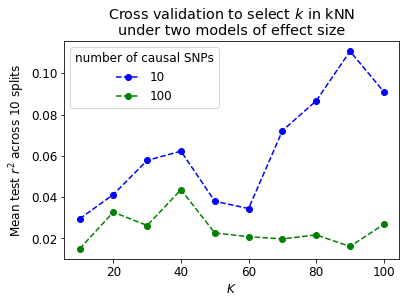

In [489]:
plt.plot(ks, r2s_knn_10, linestyle='--', marker='o', color='b', label = 10)
plt.plot(ks, r2s_knn_100, linestyle='--', marker='o', color='g', label = 100)
#plt.xscale("log")
plt.ylabel("Mean test $r^2$ across 10 splits")
plt.xlabel("$K$")
plt.title("Cross validation to select $k$ in kNN\nunder two models of effect size")
plt.legend(title = "number of causal SNPs")
plt.savefig("knn_crossvalidation.jpg", dpi=600)
plt.show()

For 10 causal loci, the optimal choice of $k$ is 90. For 100 causal loci, the best is $k=40$.

#### Random forest

In [177]:
# custom loss function
def my_loss_func(y_true, y_pred):
    return calc_corr(y_true, y_pred)[0]

my_scorer = make_scorer(my_loss_func, greater_is_better=True)

params = {"n_estimators":[100, 500, 1000, 10000],
          "max_features":[32, 75, 100, 500, 1000],
          "max_depth":[10, 50, 100, 500, 1000]}

# cross validation for 10 causal loci
cv_train_geno = np.hstack([genos[0], genos[3]])
cv_train_pheno_10 = np.hstack([true_phenos_10[0], true_phenos_10[3]])

modrf = RandomForestRegressor()
modrf_grid = GridSearchCV(modrf, params, cv=5, verbose=2, scoring=my_scorer)
modrf_grid.fit(X=cv_train_geno.T, y=cv_train_pheno_10)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] max_depth=10, max_features=32, n_estimators=100 .................
[CV] .. max_depth=10, max_features=32, n_estimators=100, total=   0.1s
[CV] max_depth=10, max_features=32, n_estimators=100 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .. max_depth=10, max_features=32, n_estimators=100, total=   0.1s
[CV] max_depth=10, max_features=32, n_estimators=100 .................
[CV] .. max_depth=10, max_features=32, n_estimators=100, total=   0.1s
[CV] max_depth=10, max_features=32, n_estimators=100 .................
[CV] .. max_depth=10, max_features=32, n_estimators=100, total=   0.1s
[CV] max_depth=10, max_features=32, n_estimators=100 .................
[CV] .. max_depth=10, max_features=32, n_estimators=100, total=   0.1s
[CV] max_depth=10, max_features=32, n_estimators=500 .................
[CV] .. max_depth=10, max_features=32, n_estimators=500, total=   0.6s
[CV] max_depth=10, max_features=32, n_estimators=500 .................
[CV] .. max_depth=10, max_features=32, n_estimators=500, total=   0.6s
[CV] max_depth=10, max_features=32, n_estimators=500 .................
[CV] .. max_depth=10, max_features=32, n_estimators=500, total=   0.6s
[CV] max_depth=10, max_features=32, n_estimators=500 .................
[CV] .

[CV]  max_depth=10, max_features=100, n_estimators=10000, total=  20.1s
[CV] max_depth=10, max_features=500, n_estimators=100 ................
[CV] . max_depth=10, max_features=500, n_estimators=100, total=   0.7s
[CV] max_depth=10, max_features=500, n_estimators=100 ................
[CV] . max_depth=10, max_features=500, n_estimators=100, total=   0.7s
[CV] max_depth=10, max_features=500, n_estimators=100 ................
[CV] . max_depth=10, max_features=500, n_estimators=100, total=   0.7s
[CV] max_depth=10, max_features=500, n_estimators=100 ................
[CV] . max_depth=10, max_features=500, n_estimators=100, total=   0.7s
[CV] max_depth=10, max_features=500, n_estimators=100 ................
[CV] . max_depth=10, max_features=500, n_estimators=100, total=   0.7s
[CV] max_depth=10, max_features=500, n_estimators=500 ................
[CV] . max_depth=10, max_features=500, n_estimators=500, total=   3.3s
[CV] max_depth=10, max_features=500, n_estimators=500 ................
[CV] 

[CV]  max_depth=50, max_features=32, n_estimators=10000, total=  14.6s
[CV] max_depth=50, max_features=32, n_estimators=10000 ...............
[CV]  max_depth=50, max_features=32, n_estimators=10000, total=  15.1s
[CV] max_depth=50, max_features=32, n_estimators=10000 ...............
[CV]  max_depth=50, max_features=32, n_estimators=10000, total=  14.7s
[CV] max_depth=50, max_features=75, n_estimators=100 .................
[CV] .. max_depth=50, max_features=75, n_estimators=100, total=   0.2s
[CV] max_depth=50, max_features=75, n_estimators=100 .................
[CV] .. max_depth=50, max_features=75, n_estimators=100, total=   0.2s
[CV] max_depth=50, max_features=75, n_estimators=100 .................
[CV] .. max_depth=50, max_features=75, n_estimators=100, total=   0.2s
[CV] max_depth=50, max_features=75, n_estimators=100 .................
[CV] .. max_depth=50, max_features=75, n_estimators=100, total=   0.2s
[CV] max_depth=50, max_features=75, n_estimators=100 .................
[CV] .

[CV]  max_depth=50, max_features=500, n_estimators=10000, total= 1.2min
[CV] max_depth=50, max_features=500, n_estimators=10000 ..............
[CV]  max_depth=50, max_features=500, n_estimators=10000, total= 1.1min
[CV] max_depth=50, max_features=500, n_estimators=10000 ..............
[CV]  max_depth=50, max_features=500, n_estimators=10000, total= 1.1min
[CV] max_depth=50, max_features=500, n_estimators=10000 ..............
[CV]  max_depth=50, max_features=500, n_estimators=10000, total= 1.2min
[CV] max_depth=50, max_features=500, n_estimators=10000 ..............
[CV]  max_depth=50, max_features=500, n_estimators=10000, total= 1.1min
[CV] max_depth=50, max_features=1000, n_estimators=100 ...............
[CV]  max_depth=50, max_features=1000, n_estimators=100, total=   1.3s
[CV] max_depth=50, max_features=1000, n_estimators=100 ...............
[CV]  max_depth=50, max_features=1000, n_estimators=100, total=   1.3s
[CV] max_depth=50, max_features=1000, n_estimators=100 ...............
[

[CV]  max_depth=100, max_features=75, n_estimators=1000, total=   1.7s
[CV] max_depth=100, max_features=75, n_estimators=1000 ...............
[CV]  max_depth=100, max_features=75, n_estimators=1000, total=   1.7s
[CV] max_depth=100, max_features=75, n_estimators=10000 ..............
[CV]  max_depth=100, max_features=75, n_estimators=10000, total=  17.3s
[CV] max_depth=100, max_features=75, n_estimators=10000 ..............
[CV]  max_depth=100, max_features=75, n_estimators=10000, total=  17.3s
[CV] max_depth=100, max_features=75, n_estimators=10000 ..............
[CV]  max_depth=100, max_features=75, n_estimators=10000, total=  17.3s
[CV] max_depth=100, max_features=75, n_estimators=10000 ..............
[CV]  max_depth=100, max_features=75, n_estimators=10000, total=  17.3s
[CV] max_depth=100, max_features=75, n_estimators=10000 ..............
[CV]  max_depth=100, max_features=75, n_estimators=10000, total=  17.7s
[CV] max_depth=100, max_features=100, n_estimators=100 ...............
[

[CV]  max_depth=100, max_features=1000, n_estimators=1000, total=  13.4s
[CV] max_depth=100, max_features=1000, n_estimators=1000 .............
[CV]  max_depth=100, max_features=1000, n_estimators=1000, total=  13.4s
[CV] max_depth=100, max_features=1000, n_estimators=1000 .............
[CV]  max_depth=100, max_features=1000, n_estimators=1000, total=  13.5s
[CV] max_depth=100, max_features=1000, n_estimators=1000 .............
[CV]  max_depth=100, max_features=1000, n_estimators=1000, total=  13.4s
[CV] max_depth=100, max_features=1000, n_estimators=10000 ............
[CV]  max_depth=100, max_features=1000, n_estimators=10000, total= 2.2min
[CV] max_depth=100, max_features=1000, n_estimators=10000 ............
[CV]  max_depth=100, max_features=1000, n_estimators=10000, total= 2.2min
[CV] max_depth=100, max_features=1000, n_estimators=10000 ............
[CV]  max_depth=100, max_features=1000, n_estimators=10000, total= 2.2min
[CV] max_depth=100, max_features=1000, n_estimators=10000 ..

[CV]  max_depth=500, max_features=100, n_estimators=500, total=   1.3s
[CV] max_depth=500, max_features=100, n_estimators=1000 ..............
[CV]  max_depth=500, max_features=100, n_estimators=1000, total=   3.6s
[CV] max_depth=500, max_features=100, n_estimators=1000 ..............
[CV]  max_depth=500, max_features=100, n_estimators=1000, total=   2.1s
[CV] max_depth=500, max_features=100, n_estimators=1000 ..............
[CV]  max_depth=500, max_features=100, n_estimators=1000, total=   2.3s
[CV] max_depth=500, max_features=100, n_estimators=1000 ..............
[CV]  max_depth=500, max_features=100, n_estimators=1000, total=   2.7s
[CV] max_depth=500, max_features=100, n_estimators=1000 ..............
[CV]  max_depth=500, max_features=100, n_estimators=1000, total=   2.3s
[CV] max_depth=500, max_features=100, n_estimators=10000 .............
[CV]  max_depth=500, max_features=100, n_estimators=10000, total=  22.0s
[CV] max_depth=500, max_features=100, n_estimators=10000 .............

[CV]  max_depth=1000, max_features=32, n_estimators=500, total=   0.6s
[CV] max_depth=1000, max_features=32, n_estimators=500 ...............
[CV]  max_depth=1000, max_features=32, n_estimators=500, total=   0.6s
[CV] max_depth=1000, max_features=32, n_estimators=500 ...............
[CV]  max_depth=1000, max_features=32, n_estimators=500, total=   0.6s
[CV] max_depth=1000, max_features=32, n_estimators=1000 ..............
[CV]  max_depth=1000, max_features=32, n_estimators=1000, total=   1.2s
[CV] max_depth=1000, max_features=32, n_estimators=1000 ..............
[CV]  max_depth=1000, max_features=32, n_estimators=1000, total=   1.4s
[CV] max_depth=1000, max_features=32, n_estimators=1000 ..............
[CV]  max_depth=1000, max_features=32, n_estimators=1000, total=   1.3s
[CV] max_depth=1000, max_features=32, n_estimators=1000 ..............
[CV]  max_depth=1000, max_features=32, n_estimators=1000, total=   1.2s
[CV] max_depth=1000, max_features=32, n_estimators=1000 ..............
[C

[CV]  max_depth=1000, max_features=500, n_estimators=500, total=   3.7s
[CV] max_depth=1000, max_features=500, n_estimators=500 ..............
[CV]  max_depth=1000, max_features=500, n_estimators=500, total=   3.7s
[CV] max_depth=1000, max_features=500, n_estimators=500 ..............
[CV]  max_depth=1000, max_features=500, n_estimators=500, total=   3.5s
[CV] max_depth=1000, max_features=500, n_estimators=500 ..............
[CV]  max_depth=1000, max_features=500, n_estimators=500, total=   3.7s
[CV] max_depth=1000, max_features=500, n_estimators=500 ..............
[CV]  max_depth=1000, max_features=500, n_estimators=500, total=   3.4s
[CV] max_depth=1000, max_features=500, n_estimators=1000 .............
[CV]  max_depth=1000, max_features=500, n_estimators=1000, total=   7.3s
[CV] max_depth=1000, max_features=500, n_estimators=1000 .............
[CV]  max_depth=1000, max_features=500, n_estimators=1000, total=   7.0s
[CV] max_depth=1000, max_features=500, n_estimators=1000 ...........

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 124.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 500, 1000, 10000], 'max_features': [32, 75, 100, 500, 1000], 'max_depth': [10, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(my_loss_func), verbose=2)

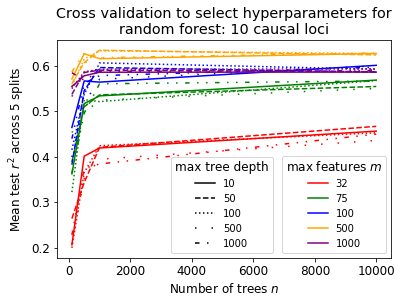

In [496]:
cvresults = pd.DataFrame(modrf_grid.cv_results_)

colors = ["red", "green", "blue", "orange", "purple"]
linetypes = ["solid", "dashed", "dotted", (0, (1, 10)), (0, (3, 5, 1, 5, 1, 5))]

for c,v in enumerate([32, 75, 100, 500, 1000]):
    ix = np.where(cvresults["param_max_features"] == v)[0]
    for c1,v1 in enumerate([10, 50, 100, 500, 1000]):
        ix1 = np.where(cvresults["param_max_depth"] == v1)[0]
        ix2 = set(ix) & set(ix1)
        plt.plot(cvresults["param_n_estimators"][ix2], cvresults["mean_test_score"][ix2]**2, 
                 color = colors[c], linestyle=linetypes[c1])

legend_elements = []  
legend_elements1 = [] 

for c,v in enumerate([32, 75, 100, 500, 1000]):
    legend_elements.append(Line2D([0], [0], color = colors[c], label=str(v)))

for c,v in enumerate([10, 50, 100, 500, 1000]):
    legend_elements1.append(Line2D([0], [0], color = "black", linestyle=linetypes[c], label=str(v)))

plt.plot()
first_legend = plt.legend(handles=legend_elements, loc="lower right",bbox_to_anchor=(1, 0), title = "max features $m$", fontsize=10)
plt.gca().add_artist(first_legend)
plt.legend(handles=legend_elements1, loc="lower right",bbox_to_anchor=(0.66, 0), title = "max tree depth", fontsize=10)
plt.xlabel("Number of trees $n$")
plt.ylabel("Mean test $r^2$ across 5 splits")
plt.title("Cross validation to select hyperparameters for\nrandom forest: 10 causal loci")
plt.savefig("RandomForest_Hyperparam_tuning_10loci.jpg", dpi=600)
plt.show()

In [412]:
bestparams = modrf_grid.best_params_
print("Best parameters for 10 causal loci: ", bestparams)

Best parameters for 10 causal loci:  {'max_depth': 50, 'max_features': 500, 'n_estimators': 1000}


In [414]:
# cross validation for 100 causal loci

cv_train_pheno_100 = np.hstack([true_phenos_100[0], true_phenos_100[3]])

modrf100 = RandomForestRegressor()
modrf100_grid = GridSearchCV(modrf100, params, cv=5, verbose=2, scoring=my_scorer)
modrf100_grid.fit(X=cv_train_geno.T, y=cv_train_pheno_100)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] max_depth=10, max_features=32, n_estimators=100 .................
[CV] .. max_depth=10, max_features=32, n_estimators=100, total=   0.1s
[CV] max_depth=10, max_features=32, n_estimators=100 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .. max_depth=10, max_features=32, n_estimators=100, total=   0.1s
[CV] max_depth=10, max_features=32, n_estimators=100 .................
[CV] .. max_depth=10, max_features=32, n_estimators=100, total=   0.1s
[CV] max_depth=10, max_features=32, n_estimators=100 .................
[CV] .. max_depth=10, max_features=32, n_estimators=100, total=   0.1s
[CV] max_depth=10, max_features=32, n_estimators=100 .................
[CV] .. max_depth=10, max_features=32, n_estimators=100, total=   0.1s
[CV] max_depth=10, max_features=32, n_estimators=500 .................
[CV] .. max_depth=10, max_features=32, n_estimators=500, total=   0.6s
[CV] max_depth=10, max_features=32, n_estimators=500 .................
[CV] .. max_depth=10, max_features=32, n_estimators=500, total=   0.6s
[CV] max_depth=10, max_features=32, n_estimators=500 .................
[CV] .. max_depth=10, max_features=32, n_estimators=500, total=   0.7s
[CV] max_depth=10, max_features=32, n_estimators=500 .................
[CV] .

[CV]  max_depth=10, max_features=100, n_estimators=10000, total=  22.7s
[CV] max_depth=10, max_features=500, n_estimators=100 ................
[CV] . max_depth=10, max_features=500, n_estimators=100, total=   0.7s
[CV] max_depth=10, max_features=500, n_estimators=100 ................
[CV] . max_depth=10, max_features=500, n_estimators=100, total=   0.7s
[CV] max_depth=10, max_features=500, n_estimators=100 ................
[CV] . max_depth=10, max_features=500, n_estimators=100, total=   0.7s
[CV] max_depth=10, max_features=500, n_estimators=100 ................
[CV] . max_depth=10, max_features=500, n_estimators=100, total=   0.7s
[CV] max_depth=10, max_features=500, n_estimators=100 ................
[CV] . max_depth=10, max_features=500, n_estimators=100, total=   0.7s
[CV] max_depth=10, max_features=500, n_estimators=500 ................
[CV] . max_depth=10, max_features=500, n_estimators=500, total=   3.5s
[CV] max_depth=10, max_features=500, n_estimators=500 ................
[CV] 

[CV]  max_depth=50, max_features=32, n_estimators=10000, total=  13.2s
[CV] max_depth=50, max_features=32, n_estimators=10000 ...............
[CV]  max_depth=50, max_features=32, n_estimators=10000, total=  12.6s
[CV] max_depth=50, max_features=32, n_estimators=10000 ...............
[CV]  max_depth=50, max_features=32, n_estimators=10000, total=  11.9s
[CV] max_depth=50, max_features=75, n_estimators=100 .................
[CV] .. max_depth=50, max_features=75, n_estimators=100, total=   0.2s
[CV] max_depth=50, max_features=75, n_estimators=100 .................
[CV] .. max_depth=50, max_features=75, n_estimators=100, total=   0.2s
[CV] max_depth=50, max_features=75, n_estimators=100 .................
[CV] .. max_depth=50, max_features=75, n_estimators=100, total=   0.2s
[CV] max_depth=50, max_features=75, n_estimators=100 .................
[CV] .. max_depth=50, max_features=75, n_estimators=100, total=   0.2s
[CV] max_depth=50, max_features=75, n_estimators=100 .................
[CV] .

[CV]  max_depth=50, max_features=500, n_estimators=10000, total= 1.2min
[CV] max_depth=50, max_features=500, n_estimators=10000 ..............
[CV]  max_depth=50, max_features=500, n_estimators=10000, total= 1.2min
[CV] max_depth=50, max_features=500, n_estimators=10000 ..............
[CV]  max_depth=50, max_features=500, n_estimators=10000, total= 1.2min
[CV] max_depth=50, max_features=500, n_estimators=10000 ..............
[CV]  max_depth=50, max_features=500, n_estimators=10000, total= 1.2min
[CV] max_depth=50, max_features=500, n_estimators=10000 ..............
[CV]  max_depth=50, max_features=500, n_estimators=10000, total= 1.2min
[CV] max_depth=50, max_features=1000, n_estimators=100 ...............
[CV]  max_depth=50, max_features=1000, n_estimators=100, total=   1.3s
[CV] max_depth=50, max_features=1000, n_estimators=100 ...............
[CV]  max_depth=50, max_features=1000, n_estimators=100, total=   1.3s
[CV] max_depth=50, max_features=1000, n_estimators=100 ...............
[

[CV]  max_depth=100, max_features=75, n_estimators=1000, total=   1.7s
[CV] max_depth=100, max_features=75, n_estimators=1000 ...............
[CV]  max_depth=100, max_features=75, n_estimators=1000, total=   1.7s
[CV] max_depth=100, max_features=75, n_estimators=10000 ..............
[CV]  max_depth=100, max_features=75, n_estimators=10000, total=  17.7s
[CV] max_depth=100, max_features=75, n_estimators=10000 ..............
[CV]  max_depth=100, max_features=75, n_estimators=10000, total=  17.6s
[CV] max_depth=100, max_features=75, n_estimators=10000 ..............
[CV]  max_depth=100, max_features=75, n_estimators=10000, total=  17.6s
[CV] max_depth=100, max_features=75, n_estimators=10000 ..............
[CV]  max_depth=100, max_features=75, n_estimators=10000, total=  17.3s
[CV] max_depth=100, max_features=75, n_estimators=10000 ..............
[CV]  max_depth=100, max_features=75, n_estimators=10000, total=  17.6s
[CV] max_depth=100, max_features=100, n_estimators=100 ...............
[

[CV]  max_depth=100, max_features=1000, n_estimators=1000, total=  13.0s
[CV] max_depth=100, max_features=1000, n_estimators=1000 .............
[CV]  max_depth=100, max_features=1000, n_estimators=1000, total=  13.0s
[CV] max_depth=100, max_features=1000, n_estimators=1000 .............
[CV]  max_depth=100, max_features=1000, n_estimators=1000, total=  12.9s
[CV] max_depth=100, max_features=1000, n_estimators=1000 .............
[CV]  max_depth=100, max_features=1000, n_estimators=1000, total=  13.1s
[CV] max_depth=100, max_features=1000, n_estimators=10000 ............
[CV]  max_depth=100, max_features=1000, n_estimators=10000, total= 2.2min
[CV] max_depth=100, max_features=1000, n_estimators=10000 ............
[CV]  max_depth=100, max_features=1000, n_estimators=10000, total= 2.2min
[CV] max_depth=100, max_features=1000, n_estimators=10000 ............
[CV]  max_depth=100, max_features=1000, n_estimators=10000, total= 2.2min
[CV] max_depth=100, max_features=1000, n_estimators=10000 ..

[CV]  max_depth=500, max_features=100, n_estimators=500, total=   1.0s
[CV] max_depth=500, max_features=100, n_estimators=1000 ..............
[CV]  max_depth=500, max_features=100, n_estimators=1000, total=   2.1s
[CV] max_depth=500, max_features=100, n_estimators=1000 ..............
[CV]  max_depth=500, max_features=100, n_estimators=1000, total=   2.1s
[CV] max_depth=500, max_features=100, n_estimators=1000 ..............
[CV]  max_depth=500, max_features=100, n_estimators=1000, total=   2.1s
[CV] max_depth=500, max_features=100, n_estimators=1000 ..............
[CV]  max_depth=500, max_features=100, n_estimators=1000, total=   2.0s
[CV] max_depth=500, max_features=100, n_estimators=1000 ..............
[CV]  max_depth=500, max_features=100, n_estimators=1000, total=   2.1s
[CV] max_depth=500, max_features=100, n_estimators=10000 .............
[CV]  max_depth=500, max_features=100, n_estimators=10000, total=  21.0s
[CV] max_depth=500, max_features=100, n_estimators=10000 .............

[CV]  max_depth=1000, max_features=32, n_estimators=500, total=   0.6s
[CV] max_depth=1000, max_features=32, n_estimators=500 ...............
[CV]  max_depth=1000, max_features=32, n_estimators=500, total=   0.6s
[CV] max_depth=1000, max_features=32, n_estimators=500 ...............
[CV]  max_depth=1000, max_features=32, n_estimators=500, total=   0.6s
[CV] max_depth=1000, max_features=32, n_estimators=1000 ..............
[CV]  max_depth=1000, max_features=32, n_estimators=1000, total=   1.2s
[CV] max_depth=1000, max_features=32, n_estimators=1000 ..............
[CV]  max_depth=1000, max_features=32, n_estimators=1000, total=   1.2s
[CV] max_depth=1000, max_features=32, n_estimators=1000 ..............
[CV]  max_depth=1000, max_features=32, n_estimators=1000, total=   1.2s
[CV] max_depth=1000, max_features=32, n_estimators=1000 ..............
[CV]  max_depth=1000, max_features=32, n_estimators=1000, total=   1.2s
[CV] max_depth=1000, max_features=32, n_estimators=1000 ..............
[C

[CV]  max_depth=1000, max_features=500, n_estimators=500, total=   3.5s
[CV] max_depth=1000, max_features=500, n_estimators=500 ..............
[CV]  max_depth=1000, max_features=500, n_estimators=500, total=   3.5s
[CV] max_depth=1000, max_features=500, n_estimators=500 ..............
[CV]  max_depth=1000, max_features=500, n_estimators=500, total=   3.5s
[CV] max_depth=1000, max_features=500, n_estimators=500 ..............
[CV]  max_depth=1000, max_features=500, n_estimators=500, total=   3.5s
[CV] max_depth=1000, max_features=500, n_estimators=500 ..............
[CV]  max_depth=1000, max_features=500, n_estimators=500, total=   3.5s
[CV] max_depth=1000, max_features=500, n_estimators=1000 .............
[CV]  max_depth=1000, max_features=500, n_estimators=1000, total=   7.2s
[CV] max_depth=1000, max_features=500, n_estimators=1000 .............
[CV]  max_depth=1000, max_features=500, n_estimators=1000, total=   7.0s
[CV] max_depth=1000, max_features=500, n_estimators=1000 ...........

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 122.6min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 500, 1000, 10000], 'max_features': [32, 75, 100, 500, 1000], 'max_depth': [10, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(my_loss_func), verbose=2)

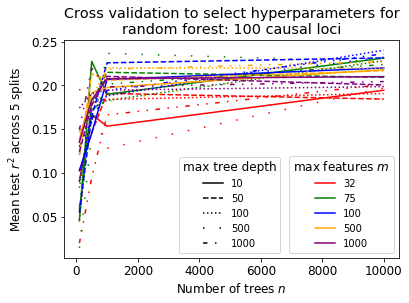

In [498]:
cvresults100 = pd.DataFrame(modrf100_grid.cv_results_)

for c,v in enumerate([32, 75, 100, 500, 1000]):
    ix = np.where(cvresults100["param_max_features"] == v)[0]
    for c1,v1 in enumerate([10, 50, 100, 500, 1000]):
        ix1 = np.where(cvresults100["param_max_depth"] == v1)[0]
        ix2 = set(ix) & set(ix1)
        plt.plot(cvresults100["param_n_estimators"][ix2], cvresults100["mean_test_score"][ix2]**2, 
                 color = colors[c], linestyle=linetypes[c1])
plt.plot()
first_legend = plt.legend(handles=legend_elements, loc="lower right",bbox_to_anchor=(1, 0), title = "max features $m$", fontsize=10)
plt.gca().add_artist(first_legend)
plt.legend(handles=legend_elements1, loc="lower right",bbox_to_anchor=(0.66, 0), title = "max tree depth", fontsize=10)
plt.xlabel("Number of trees $n$")
plt.ylabel("Mean test $r^2$ across 5 splits")
plt.title("Cross validation to select hyperparameters for\nrandom forest: 100 causal loci")
plt.savefig("RandomForest_Hyperparam_tuning_100loci.jpg", dpi=600)
plt.show()

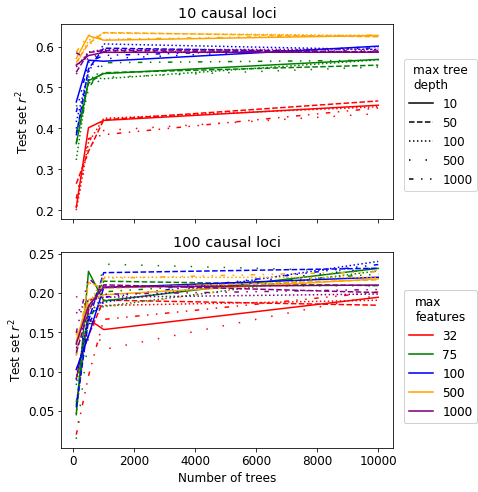

In [765]:
cvresults = pd.DataFrame(modrf_grid.cv_results_)

colors = ["red", "green", "blue", "orange", "purple"]
linetypes = ["solid", "dashed", "dotted", (0, (1, 10)), (0, (3, 5, 1, 5, 1, 5))]

# stacked plots
f, axarr = plt.subplots(2, 1, sharex=True, figsize=(6.5,7))

for c,v in enumerate([32, 75, 100, 500, 1000]):
    ix = np.where(cvresults["param_max_features"] == v)[0]
    for c1,v1 in enumerate([10, 50, 100, 500, 1000]):
        ix1 = np.where(cvresults["param_max_depth"] == v1)[0]
        ix2 = set(ix) & set(ix1)
        axarr[0].plot(cvresults["param_n_estimators"][ix2], cvresults["mean_test_score"][ix2]**2, 
                     color = colors[c], linestyle=linetypes[c1])

for c,v in enumerate([32, 75, 100, 500, 1000]):
    ix = np.where(cvresults100["param_max_features"] == v)[0]
    for c1,v1 in enumerate([10, 50, 100, 500, 1000]):
        ix1 = np.where(cvresults100["param_max_depth"] == v1)[0]
        ix2 = set(ix) & set(ix1)
        axarr[1].plot(cvresults100["param_n_estimators"][ix2], cvresults100["mean_test_score"][ix2]**2, 
                     color = colors[c], linestyle=linetypes[c1])

axarr[0].set_title('10 causal loci')
axarr[1].set_title('100 causal loci')

first_legend = plt.figlegend(handles=legend_elements, loc="lower left",
                             bbox_to_anchor=(0.85, 0.125), title = "max\nfeatures", fontsize=12)
plt.gca().add_artist(first_legend)
plt.figlegend(handles=legend_elements1, loc="lower left",
              bbox_to_anchor=(0.85, 0.585), title = "max tree\ndepth", fontsize=12)

for ax in axarr.flat:
    ax.set(ylabel='Test set $r^2$', xlabel = "Number of trees")
    ax.label_outer() 

plt.tight_layout()
plt.savefig("rf_cv_stacked.jpg", dpi=300, bbox_inches="tight", pad_inches = 0.2)
plt.show()

In [416]:
bestparams100 = modrf100_grid.best_params_
print("Best parameters for 100 causal loci: ", bestparams100)

Best parameters for 100 causal loci:  {'max_depth': 100, 'max_features': 100, 'n_estimators': 10000}


In [417]:
def rf_fit_predict(geno_train, pheno_train, geno_test, params_in):
    """    
    geno_train: genotype matrix of training data (rows are SNPs, columns are individual genotypes)
    geno_test: genotype matrix of testing data
    pheno_train: phenotype vector of training data
    params_in: dict of max_depth, max_features, and n_estimators. Can be optained e.g. by performing
        CVgridsearch and calling .bets_params_
    
    returns predicted phenotypes of test set
    """  
    regr = RandomForestRegressor(max_depth=params_in['max_depth'], 
                                 n_estimators = params_in['n_estimators'],
                                 max_features = params_in['max_features'])
    
    regr.fit(X=geno_train.T, y=pheno_train)
    return modrf_grid.predict(geno_test.T)

#### Polygenic risk score 

In [709]:
def calc_af(geno):
    """
    calculate allele freq
    first mask if any values are not in [0, 1, 2]
    """
    geno = ma.masked_where(geno > 2, geno)
    return geno.mean(axis=1).filled(-1) / 2

def normalize_geno(geno, afs):
    """normalize genotype matrix"""
    geno_norm = ((geno - 2*afs) / np.sqrt(2*afs*(1-afs)))
    if ma.isMaskedArray(geno_norm):
        geno_norm = geno_norm.filled(0)
    return geno_norm  

def prs(geno_train, pheno_train, geno_test, thresh):
    """
    performs polygenic risk scoring, applying p-value thresholding
    thresh must be chi^2 statistic (use scipy.stats.chi2.ppf to convert from P value)
    """
    # note that test genotype must be normalized with af from training set
    af_train = calc_af(geno_train).reshape(-1,1)
    geno_train_norm = normalize_geno(geno_train, af_train)
    geno_test_norm = normalize_geno(geno_test, af_train)
    pheno_train_mean = np.mean(pheno_train)
    pheno_train_sd = np.sqrt(np.var(pheno_train))
    pheno_train_norm = (pheno_train - pheno_train_mean) / pheno_train_sd
    ATT = calc_ATT(geno_train, pheno_train)
    # estimate betas
    betas = calc_corr(geno_train_norm, pheno_train_norm)[0]
    ix = np.where(ATT > thresh)[0]
    preds_norm = betas[ix].T @ geno_test.filled(0)[ix,:]
    return ((preds_norm * pheno_train_sd) + pheno_train_mean)

In [710]:
cv_train_geno = np.hstack([genos[0], genos[3]])
cv_train_pheno_10 = np.hstack([true_phenos_10[0], true_phenos_10[3]])
cv_train_pheno_100 = np.hstack([true_phenos_100[0], true_phenos_100[3]])

pval_thresholds = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 0.8]
chi2_thresholds = [chi2.ppf((1 - p), df=1) for p in pval_thresholds]

kf = KFold(n_splits=10)

r2s_10 = np.zeros_like(chi2_thresholds)
r2s_100 = np.zeros_like(chi2_thresholds)

for c,v in enumerate(chi2_thresholds):
    r2s_cv_10 = np.zeros(kf.get_n_splits())
    r2s_cv_100 = np.zeros(kf.get_n_splits())
    i = 0
    for train_index, test_index in kf.split(cv_train_geno.T):
        X_train, X_test = cv_train_geno[:,train_index], cv_train_geno[:,test_index]
        y_train_10, y_test_10 = cv_train_pheno_10[train_index], cv_train_pheno_10[test_index]
        y_train_100, y_test_100 = cv_train_pheno_100[train_index], cv_train_pheno_100[test_index]
        
        pred10 = prs(X_train, y_train_10, X_test, v)
        pred100 = prs(X_train, y_train_100, X_test, v)
        
        r2_10 = calc_corr(pred10, y_test_10)[0]
        r2_100 = calc_corr(pred100, y_test_100)[0]
        
        if np.isnan(r2_10): 
            r2s_cv_10[i] = 0
        else: 
            r2s_cv_10[i] = r2_10**2
        if np.isnan(r2_100): 
            r2s_cv_100[i] = 0
        else: 
            r2s_cv_100[i] = r2_100**2
        i += 1
    r2s_10[c] = np.mean(r2s_cv_10)
    r2s_100[c] = np.mean(r2s_cv_100)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


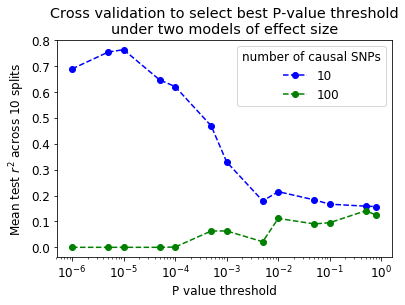

In [711]:
plt.plot(pval_thresholds, r2s_10, linestyle='--', marker='o', color='b', label = 10)
plt.plot(pval_thresholds, r2s_100, linestyle='--', marker='o', color='g', label = 100)
plt.xscale("log")
plt.ylabel("Mean test $r^2$ across 10 splits")
plt.xlabel("P value threshold")
plt.title("Cross validation to select best P-value threshold\nunder two models of effect size")
plt.legend(title = "number of causal SNPs")
plt.savefig("cv_thresholding.jpg", dpi=600)
plt.show()

In [609]:
print("best threshold for 10 causal loci: ", pval_thresholds[np.argmax(r2s_10)])
print("best threshold for 100 causal loci: ", pval_thresholds[np.argmax(r2s_100)])

best threshold for 10 causal loci:  1e-05
best threshold for 100 causal loci:  0.5


# Results

In [ ]:
pops = ["CEU", "JPT", "CHB", "CHD"]

Generate training populations for all five splits

In [511]:
test_geno = genos[2]
test_pheno10 = true_phenos_10[2]
test_pheno100 = true_phenos_100[2]

train1_geno = genos[0]
train2_geno = genos[3]
train3_geno = np.hstack([genos[0], genos[3]])
train4_geno = np.hstack([genos[0], genos[1], genos[3]])
train5_geno = np.hstack([genos[1], genos[3]])

train1_pheno_10 = true_phenos_10[0]
train2_pheno_10 = true_phenos_10[3]
train3_pheno_10 = np.hstack([true_phenos_10[0], true_phenos_10[3]])
train4_pheno_10 = np.hstack([true_phenos_10[0], true_phenos_10[1], true_phenos_10[3]])
train5_pheno_10 = np.hstack([true_phenos_10[1], true_phenos_10[3]])

train1_pheno_100 = true_phenos_100[0]
train2_pheno_100 = true_phenos_100[3]
train3_pheno_100 = np.hstack([true_phenos_100[0], true_phenos_100[3]])
train4_pheno_100 = np.hstack([true_phenos_100[0], true_phenos_100[1], true_phenos_100[3]])
train5_pheno_100 = np.hstack([true_phenos_100[1], true_phenos_100[3]])

In [517]:
# KNN predictions
kNN1_10 = KNN(train1_geno, train1_pheno_10, test_geno, 90)
kNN1_100 = KNN(train1_geno, train1_pheno_100, test_geno, 40)
kNN2_10 = KNN(train2_geno, train2_pheno_10, test_geno, 90)
kNN2_100 = KNN(train2_geno, train2_pheno_100, test_geno, 40)
kNN3_10 = KNN(train3_geno, train3_pheno_10, test_geno, 90)
kNN3_100 = KNN(train3_geno, train3_pheno_100, test_geno, 40)
kNN4_10 = KNN(train4_geno, train4_pheno_10, test_geno, 90)
kNN4_100 = KNN(train4_geno, train4_pheno_100, test_geno, 40)
kNN5_10 = KNN(train5_geno, train5_pheno_10, test_geno, 90)
kNN5_100 = KNN(train5_geno, train5_pheno_100, test_geno, 40)

In [562]:
r2s_knn_10 = [np.corrcoef(pred, test_pheno10)[0,1] for pred in [kNN1_10, kNN2_10, kNN3_10, kNN4_10, kNN5_10]]
r2s_knn_100 = [np.corrcoef(pred, test_pheno100)[0,1] for pred in [kNN1_100, kNN2_100, kNN3_100, kNN4_100, kNN5_100]]

In [565]:
# RF predictions
traingenos = [train1_geno, train2_geno, train3_geno, train4_geno, train5_geno]
trainphenos_10 = [train1_pheno_10, train2_pheno_10, train3_pheno_10, train4_pheno_10, train5_pheno_10]
trainphenos_100 = [train1_pheno_100, train2_pheno_100, train3_pheno_100, train4_pheno_100, train5_pheno_100]

r2s_rf_10 = []
r2s_rf_100 = []

for c in range(5):
    g = traingenos[c]
    rf_mod_10 = RandomForestRegressor(max_depth = bestparams['max_depth'],
                                      max_features = bestparams['max_features'],
                                      n_estimators = bestparams['n_estimators'])
    p10 = trainphenos_10[c]
    rf_mod_10.fit(g.T, p10)
    prediction_10 = rf_mod_10.predict(test_geno.T)
    r2_prediction_10 = np.corrcoef(prediction_10, test_pheno10)[0,1]
    r2s_rf_10.append(r2_prediction_10)

    rf_mod_100 = RandomForestRegressor(max_depth = bestparams100['max_depth'],
                                      max_features = bestparams100['max_features'],
                                      n_estimators = bestparams100['n_estimators'])
    p100 = trainphenos_100[c]
    rf_mod_100.fit(g.T, p100)
    prediction_100 = rf_mod_100.predict(test_geno.T)
    r2_prediction_100 = np.corrcoef(prediction_100, test_pheno100)[0,1]
    r2s_rf_100.append(r2_prediction_100)

In [604]:
# PRS predictions
# prs(geno_train, pheno_train, geno_test, thresh)
r2s_prs_10 = []
r2s_prs_100 = []

for c in range(5):
    g = traingenos[c]
    p10 = trainphenos_10[c]
    p100 = trainphenos_100[c]
    prediction_10 = prs(g, p10, test_geno, 1e-5)
    prediction_100 = prs(g, p100, test_geno, 0.5)
    r2_prediction_10 = np.corrcoef(prediction_10, test_pheno10)[0,1]
    r2_prediction_100 = np.corrcoef(prediction_100, test_pheno100)[0,1]
    r2s_prs_10.append(r2_prediction_10)
    r2s_prs_100.append(r2_prediction_100)

In [621]:
knnres = np.concatenate([np.array(r2s_knn_10)**2, np.array(r2s_knn_100)**2])
rfres = np.concatenate([np.array(r2s_rf_10)**2, np.array(r2s_rf_100)**2])
prsres = np.concatenate([np.array(r2s_prs_10)**2, np.array(r2s_prs_100)**2])

results_dat = {"train":["CEU", "CHD", "CEU + CHD", "CEU + CHD + JPT", "CHD + JPT"]*2,
              "test":["CHB"]*10,
              "causal loci":["10"]*5 + ["100"]*5,
              "kNN":knnres,
               "RF":rfres,
               "PRS":prsres}
results = pd.DataFrame(results_dat)
results

,train,test,causal loci,kNN,RF,PRS
0,CEU,CHB,10,0.048312,0.459548,0.123657
1,CHD,CHB,10,0.000914,0.461503,0.105343
2,CEU + CHD,CHB,10,0.049110,0.560887,0.062280
3,CEU + CHD + JPT,CHB,10,0.078122,0.679987,0.075085
4,CHD + JPT,CHB,10,0.085714,0.610337,0.137202
5,CEU,CHB,100,0.001700,0.124866,0.196850
6,CHD,CHB,100,0.005899,0.189720,0.048216
7,CEU + CHD,CHB,100,0.001356,0.326443,0.070144
8,CEU + CHD + JPT,CHB,100,0.087166,0.339491,0.200327
9,CHD + JPT,CHB,100,0.087166,0.321786,0.099577


In [713]:
results_rounded = {"train":["CEU", "CHD", "CEU + CHD", "CEU + CHD + JPT", "CHD + JPT"]*2,
              "test":["CHB"]*10,
              "causal loci":["10"]*5 + ["100"]*5,
              "kNN": np.round(knnres, 4),
               "RF": np.round(rfres, 4),
               "PRS": np.round(prsres, 4)}
results_round = pd.DataFrame(results_rounded)
results_round

,train,test,causal loci,kNN,RF,PRS
0,CEU,CHB,10,0.0483,0.4595,0.1237
1,CHD,CHB,10,0.0009,0.4615,0.1053
2,CEU + CHD,CHB,10,0.0491,0.5609,0.0623
3,CEU + CHD + JPT,CHB,10,0.0781,0.6800,0.0751
4,CHD + JPT,CHB,10,0.0857,0.6103,0.1372
5,CEU,CHB,100,0.0017,0.1249,0.1969
6,CHD,CHB,100,0.0059,0.1897,0.0482
7,CEU + CHD,CHB,100,0.0014,0.3264,0.0701
8,CEU + CHD + JPT,CHB,100,0.0872,0.3395,0.2003
9,CHD + JPT,CHB,100,0.0872,0.3218,0.0996


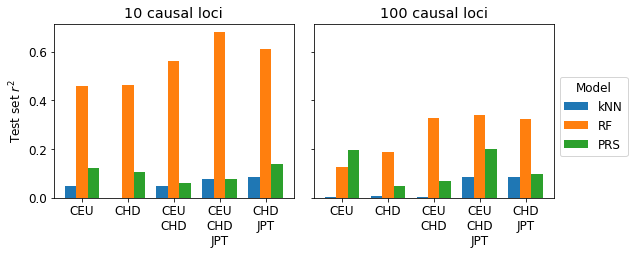

In [708]:
# Plot results
f, axarr = plt.subplots(1, 2, sharey=True, figsize=(8,3.5))
axarr[0].bar(ind - width, results['kNN'][0:5], width, label='kNN')
axarr[0].bar(ind, results['RF'][0:5], width, label='RF')
axarr[0].bar(ind + width, results['PRS'][0:5], width, label='PRS')
axarr[0].set_title('10 causal loci')

axarr[1].bar(ind - width, results['kNN'][5:10], width, label='kNN')
axarr[1].bar(ind, results['RF'][5:10], width, label='RF')
axarr[1].bar(ind + width, results['PRS'][5:10], width, label='PRS')
axarr[1].set_title('100 causal loci')

plt.figlegend(["kNN", "RF", "PRS"], loc='center right', bbox_to_anchor=(1.1, 0.55), title = "Model")

for ax in axarr.flat:
    ax.set(ylabel='Test set $r^2$')
    ax.set_xticklabels(["", "CEU", "CHD", "CEU\nCHD", "CEU\nCHD\nJPT", "CHD\nJPT"])
    ax.label_outer() 

plt.tight_layout()
plt.savefig("r2_results.jpg", dpi=600, bbox_inches="tight", pad_inches = 0.2)
plt.show()

In [772]:
# average fold increase of RF relative to PRS
np.mean((results['RF'] - results['PRS']) / results['PRS'])

3.475709149431059

In [789]:
# calc average model performance
avs_dat = {"Model":["kNN", "RF", "PRS"],
      "10 causal loci":[np.mean(results[i][0:5]) for i in ["kNN", "RF", "PRS"] ],
      "100 causal loci":[np.mean(results[i][5:10]) for i in ["kNN", "RF", "PRS"] ],
       "overall":[np.mean(results[i]) for i in ["kNN", "RF", "PRS"] ]
      }
avs = pd.DataFrame(avs_dat)
avs

,Model,10 causal loci,100 causal loci,overall
0,kNN,0.052434,0.036657,0.044546
1,RF,0.554452,0.260461,0.407457
2,PRS,0.100713,0.123023,0.111868


In [790]:
column_avs = [np.mean(avs[i]) for i in ["10 causal loci", "100 causal loci", "overall"]]
column_avs

[0.23586669594477153, 0.1400471567707141, 0.18795692635774278]